In [40]:
import pandas as pd
import ROOT
import csv
import uproot
import numpy as np
import mplhep as hep
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from array import array
from tqdm import trange
import random
import time 
import hist
from IPython.display import display, Image


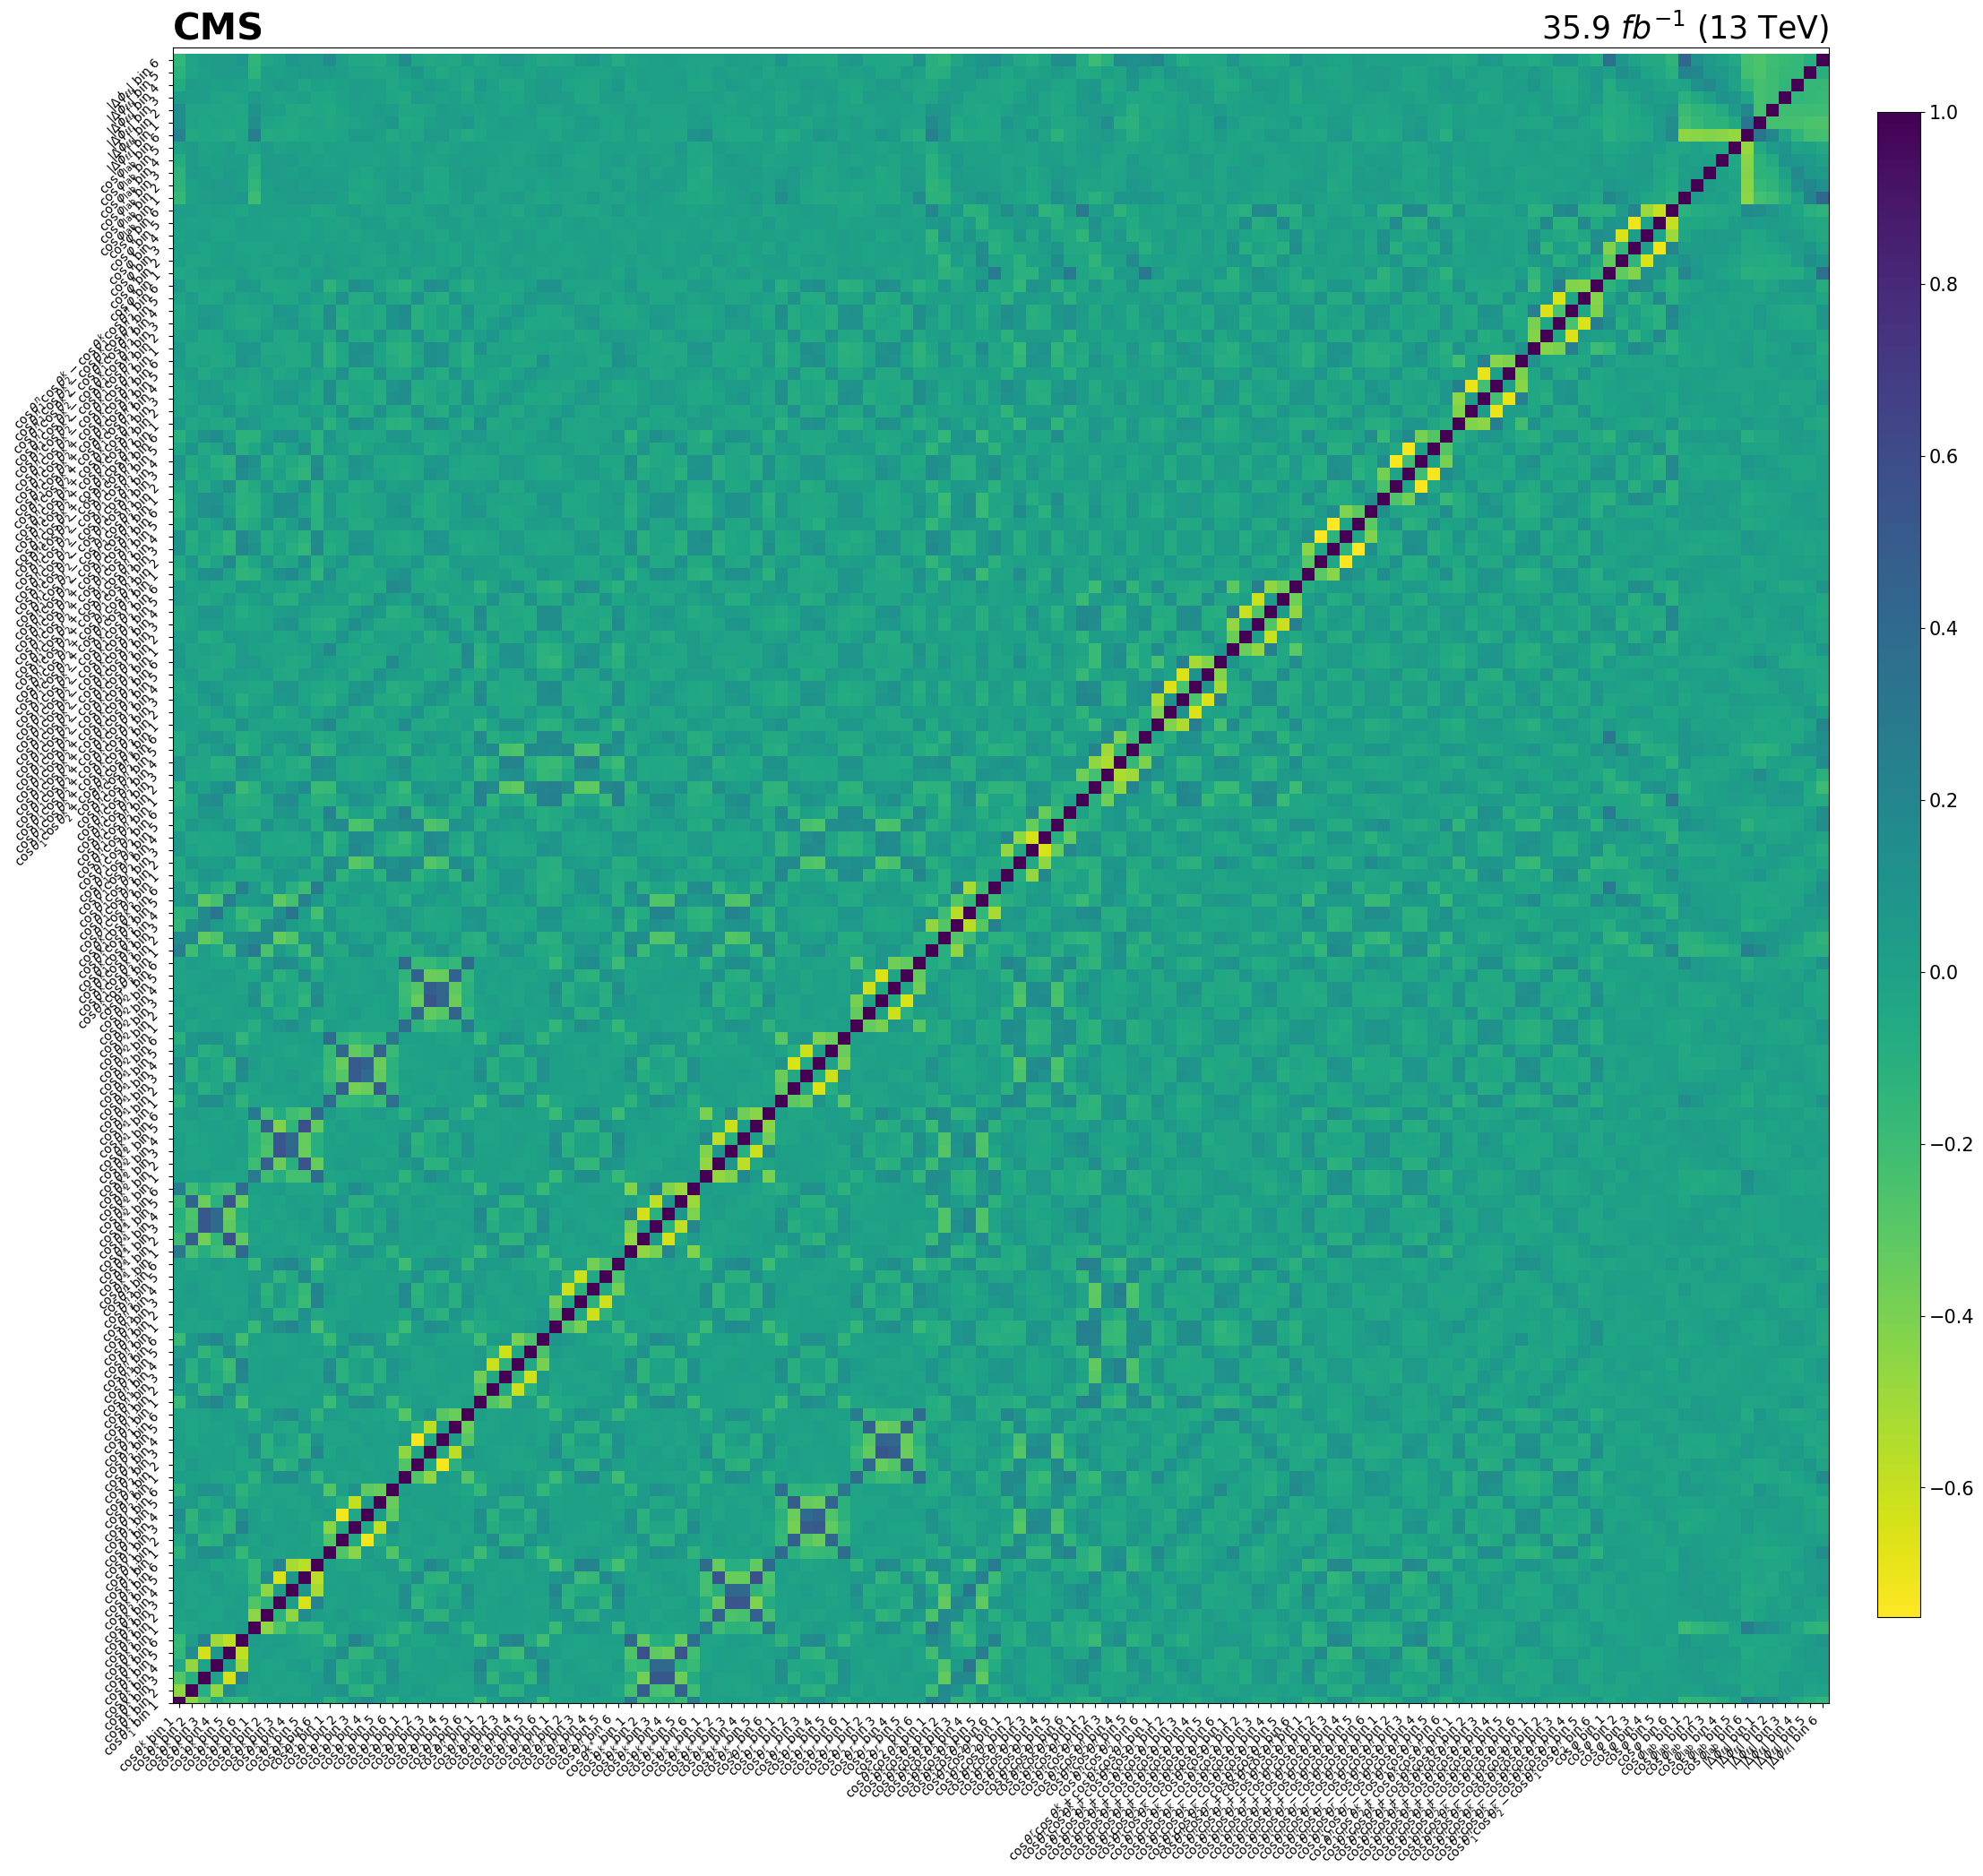

In [302]:
total_stat_mat_from_hep_data = [] 
xy_labels = []

# opening the CSV file
with open('HEPData-ins1742786-v1-Statistical_covariance_matrix.csv', mode ='r')as file:
   
    # reading the CSV file
    csvFile = csv.reader(file)

    # displaying the contents of the CSV file
    for lines in csvFile:
        if not len(lines) == 3 : continue
        if not '$' in lines[0] : continue

        xy_labels.append(str(lines[0]))
        total_stat_mat_from_hep_data.append(np.double(lines[2]))
        
xy_labels = np.reshape(xy_labels, (-1, 132));        

fig, axs = plt.subplots(1, 1, figsize=(24,24))

total_stat_mat_from_hep_data = np.array(total_stat_mat_from_hep_data)
total_stat_mat_from_hep_data = np.reshape(total_stat_mat_from_hep_data, (-1, 132))
#norm_stat = colors.Normalize(vmin=total_stat_mat_from_hep_data.min(), vmax=total_stat_mat_from_hep_data.max())

std_devs = np.sqrt(np.diag(total_stat_mat_from_hep_data))
inv_std_devs = 1.0 / std_devs
inv_std_devs_matrix = np.diag(inv_std_devs)
correlation_matrix = inv_std_devs_matrix @ total_stat_mat_from_hep_data @ inv_std_devs_matrix

im = axs.imshow(correlation_matrix, cmap='viridis_r')

axs.set_title('CMS', fontsize=30, fontweight='bold', loc="left")
axs.set_title('35.9 $fb^{-1}$ (13 TeV)', fontsize=25, loc="right")

axs.set_xticks(np.arange(0, 132))
axs.set_xticklabels(xy_labels[0], rotation=45, ha='right')

axs.set_yticks(np.arange(0, 132))
axs.set_yticklabels(xy_labels[0], rotation=45, ha='right')

#axs.colorbar()
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)
axs.set_ylim(0, 132)
#plt.savefig('stat_matrix_from_hep_data.pdf')

In [352]:
# Create a ROOT file and TH2F
root_file = ROOT.TFile("covariance_matrix/statistical_covariance_matrix.root", "RECREATE")
histogram = ROOT.TH2D("covariance_matrix", "Statistical Covariance Matrix", 
                      132, 0, 132, 132, 0, 132)

# Fill the histogram with the matrix values
for i in range(132):
    for j in range(132):
        histogram.SetBinContent(i+1, j+1, correlation_matrix[i, j])

# Write the histogram to the ROOT file
histogram.Write()

# Close the ROOT file
root_file.Close()

In [353]:
hepdata_stat_cov_matrix = uproot.open("covariance_matrix/statistical_covariance_matrix.root")

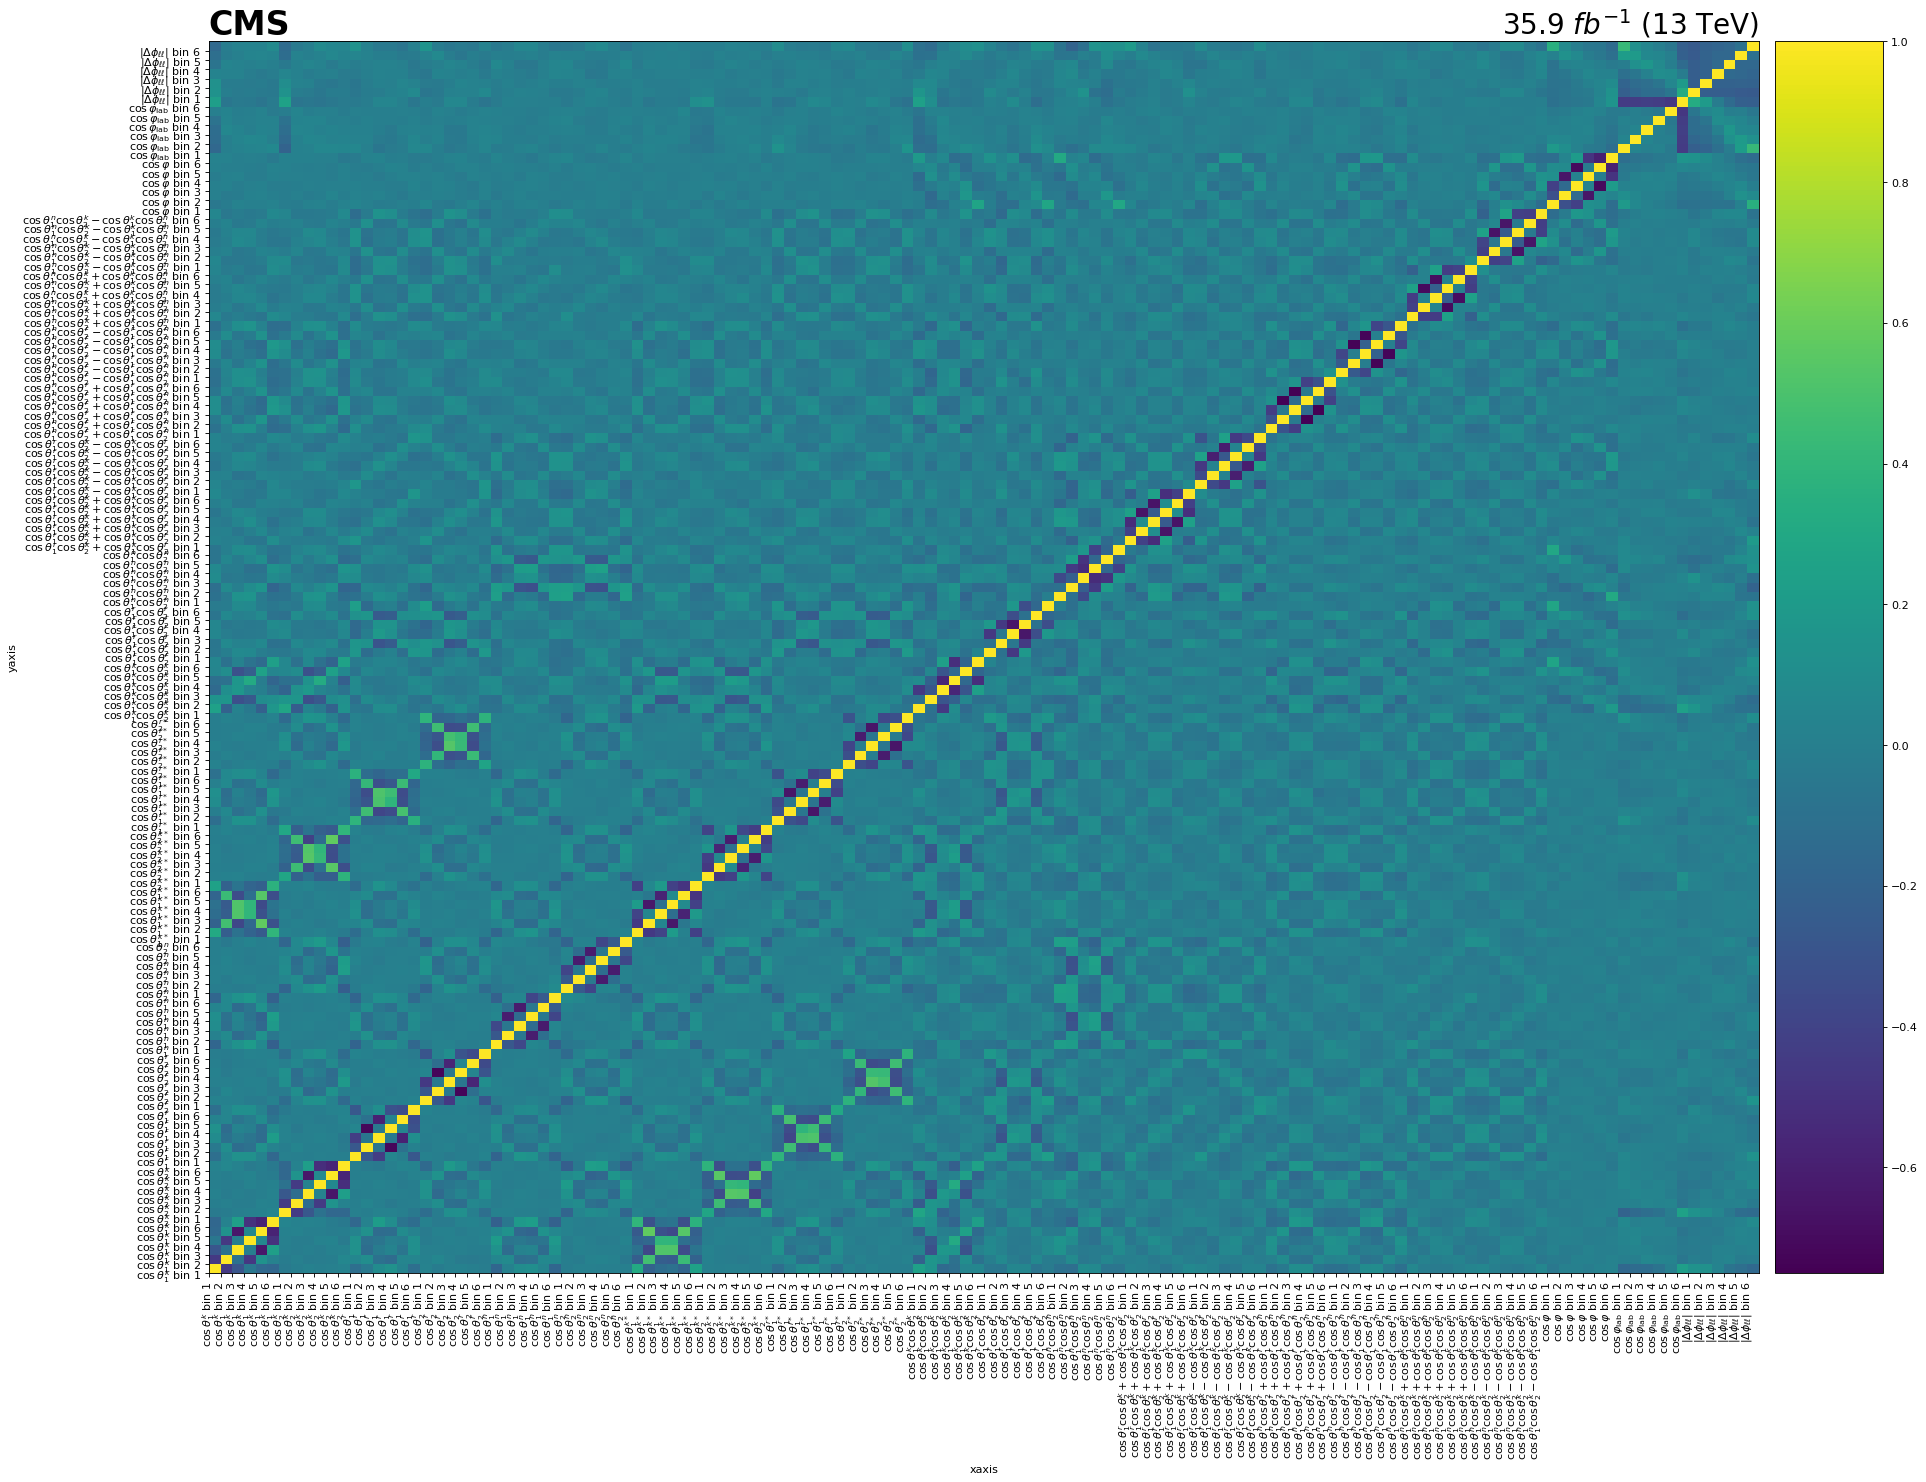

In [356]:
plt.figure(figsize=(25, 20), dpi=80)
hepdata_stat_cov_matrix['covariance_matrix'].to_hist().plot2d()
plt.title('CMS', fontsize=30, fontweight='bold', loc="left")
plt.title('35.9 $fb^{-1}$ (13 TeV)', fontsize=25, loc="right")

plt.yticks(ticks=range(len(xy_labels[0])), labels=xy_labels[0], rotation=0);
plt.xticks(ticks=range(len(xy_labels[0])), labels=xy_labels[0], rotation=90);
plt.savefig('stat_matrix_from_hep_data.pdf')

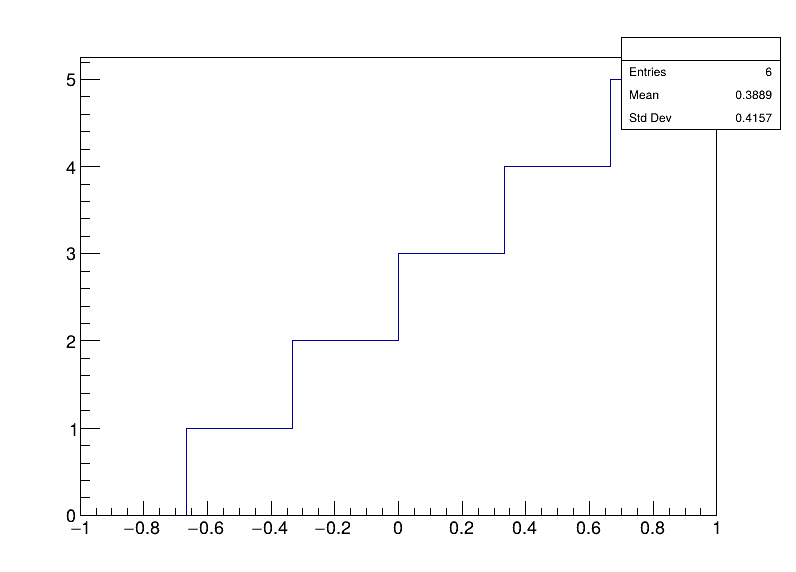

Info in <TCanvas::Print>: png file example_histogram.png has been created


In [51]:
single_th1d = ROOT.TH1D("", "", 6, -1, 1)
for i in range(1, 7):
    single_th1d.SetBinContent(i, i-1)

c1 = ROOT.TCanvas("", "", 800, 600)
single_th1d.Draw("HIST")
c1.SaveAs("example_histogram.png")
display(Image(filename="example_histogram.png"))

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f0f333c90c0>, errorbar=None, legend_artist=None)]

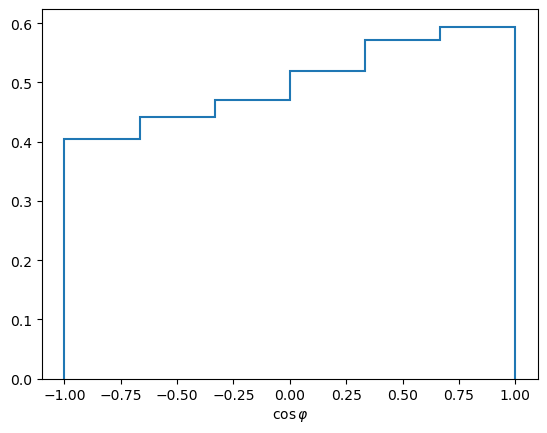

In [324]:
test_th1d = uproot.open('HEPData-ins1742786-v1-cosvarphi.root')
test_th1d['cosvarphi/Hist1D_y1;1'].to_hist().plot1d(yerr=False)

In [144]:
data

,$\cos\theta_{1}^{k*}$,$\cos\theta_{1}^{k*}$ LOW,$\cos\theta_{1}^{k*}$ HIGH,$\frac{1}{\sigma} \frac{{d}\sigma}{{d}\cos\theta_{1}^{k*}}$,stat +,stat -,sys +,sys -
0,-0.833333,-1.000000,-0.666667,0.515542,0.009785,-0.009785,0.012589,-0.012589
1,-0.500000,-0.666667,-0.333333,0.496873,0.009262,-0.009262,0.009657,-0.009657
2,-0.166666,-0.333333,0.000000,0.499811,0.007909,-0.007909,0.009724,-0.009724
3,0.166666,0.000000,0.333333,0.497015,0.008283,-0.008283,0.009797,-0.009797
4,0.500000,0.333333,0.666667,0.493344,0.009201,-0.009201,0.010076,-0.010076
5,0.833333,0.666667,1.000000,0.497416,0.009944,-0.009944,0.013206,-0.013206


In [328]:
# Mapping to connect sorting order with filenames in the directory
filenames = [
    "costheta_{1}^{k}.csv",
    "costheta_{2}^{k}.csv",
    "costheta_{1}^{r}.csv",
    "costheta_{2}^{r}.csv",
    "costheta_{1}^{n}.csv",
    "costheta_{2}^{n}.csv",
    "costheta_{1}^{k_}.csv",
    "costheta_{2}^{k_}.csv",
    "costheta_{1}^{r_}.csv",
    "costheta_{2}^{r_}.csv",    
    "costheta_{1}^{k}costheta_{2}^{k}.csv",
    "costheta_{1}^{r}costheta_{2}^{r}.csv",
    "costheta_{1}^{n}costheta_{2}^{n}.csv",
    "c_{1}^{r}c_{2}^{k}+c_{1}^{k}c_{2}^{r}.csv", 
    "c_{1}^{r}c_{2}^{k}-c_{1}^{k}c_{2}^{r}.csv", 
    "c_{1}^{n}c_{2}^{r}+c_{1}^{r}c_{2}^{n}.csv",
    "c_{1}^{n}c_{2}^{r}-c_{1}^{r}c_{2}^{n}.csv", 
    "c_{1}^{n}c_{2}^{k}+c_{1}^{k}c_{2}^{n}.csv",
    "c_{1}^{n}c_{2}^{k}-c_{1}^{k}c_{2}^{n}.csv", 
    "cosvarphi.csv",
    "cosvarphi_{mathrm{lab}}.csv",
    "_Deltaphi_{ellell}_.csv",
]

In [340]:
import uproot
import hist
import pandas as pd
import numpy as np

# Define the base directory and derive the root directory
base_dir = "HEPData-ins1742786-v1-csv"
root_dir = base_dir.replace("-csv", "-root")

# Create the root directory if it doesn't exist
os.makedirs(root_dir, exist_ok=True)

# Process each CSV file in the base directory
for filename in filenames:
    if filename.endswith(".csv"):
        # Define full CSV file path and corresponding ROOT file path
        csv_path = os.path.join(base_dir, filename)
        root_path = os.path.join(root_dir, f"{filename.replace('.csv', '')}.root")

        # Load the CSV file, skipping metadata lines
        data = pd.read_csv(csv_path, skiprows=8)  # Adjusted to skip the first 8 lines

        # Extract columns
        bin_edges_low = data[data.keys()[1]].values
        bin_edges_high = data[data.keys()[2]].values
        diff_cross_section = data[data.keys()[3]].values
        stat_uncert = data[data.keys()[4]].values
        syst_uncert = data[data.keys()[6]].values

        # Combine statistical and systematic uncertainties in quadrature
        total_uncert = np.sqrt(stat_uncert**2 + syst_uncert**2)

        # Define bin edges
        bin_edges = np.concatenate((bin_edges_low, [bin_edges_high[-1]]))

        # Create a histogram with variable bin edges and Weight() storage
        histogram = hist.Hist(hist.axis.Variable(bin_edges, name="cosθ₁^k"), storage=hist.storage.Weight())

        # Prepare structured data with values and variances
        values_with_variances = np.array(
            [(val, var**2) for val, var in zip(diff_cross_section, total_uncert)],
            dtype=[("value", "f8"), ("variance", "f8")]
        )

        # Fill the histogram with the structured array
        histogram[...] = values_with_variances

        # Plot the histogram with error bars using matplotlib directly
        # plt.errorbar(
        #     histogram.axes[0].centers,  # Bin centers
        #     histogram.view().value,      # Bin values
        #     yerr=np.sqrt(histogram.view().variance),  # Error bars
        #     fmt="o", capsize=3, capthick=1
        # )
        # plt.xlabel(f"{data.keys()[0]}")
        # plt.ylabel(f"{data.keys()[3]}")
        # plt.title("Normalized Differential Cross-Section")
        # plt.show()

        # Save the histogram to a ROOT file using uproot
        with uproot.recreate(root_path) as file:
            file["diff_cross_section"] = histogram

        print(f"Histogram ROOT file created: {root_path}")


Histogram ROOT file created: HEPData-ins1742786-v1-root/costheta_{1}^{k}.root
Histogram ROOT file created: HEPData-ins1742786-v1-root/costheta_{2}^{k}.root
Histogram ROOT file created: HEPData-ins1742786-v1-root/costheta_{1}^{r}.root
Histogram ROOT file created: HEPData-ins1742786-v1-root/costheta_{2}^{r}.root
Histogram ROOT file created: HEPData-ins1742786-v1-root/costheta_{1}^{n}.root
Histogram ROOT file created: HEPData-ins1742786-v1-root/costheta_{2}^{n}.root
Histogram ROOT file created: HEPData-ins1742786-v1-root/costheta_{1}^{k_}.root
Histogram ROOT file created: HEPData-ins1742786-v1-root/costheta_{2}^{k_}.root
Histogram ROOT file created: HEPData-ins1742786-v1-root/costheta_{1}^{r_}.root
Histogram ROOT file created: HEPData-ins1742786-v1-root/costheta_{2}^{r_}.root
Histogram ROOT file created: HEPData-ins1742786-v1-root/costheta_{1}^{k}costheta_{2}^{k}.root
Histogram ROOT file created: HEPData-ins1742786-v1-root/costheta_{1}^{r}costheta_{2}^{r}.root
Histogram ROOT file created:

In [342]:
import os
import ROOT

# Define the input directory and output ROOT file
input_dir = "HEPData-ins1742786-v1-root"
output_file = ROOT.TFile("HEPData-concatenated-histogram.root", "RECREATE")

# Initialize variables for the combined histogram
concatenated_histogram = None
bin_offset = 0  # Tracks the bin index offset as we add more histograms

# Calculate the total number of bins needed by summing bins across all histograms
total_bins = 0
for filename in filenames:
    if filename.endswith(".csv"):
        file_path = os.path.join(input_dir, filename.replace(".csv",".root"))
        input_file = ROOT.TFile.Open(file_path)
        if not input_file or input_file.IsZombie():
            print(f"Could not open file {filename}. Skipping...")
            continue
        hist = input_file.Get("diff_cross_section")
        if hist:
            total_bins += hist.GetNbinsX()
        input_file.Close()

print(f"Total bins for concatenated histogram: {total_bins}")

# Create the concatenated histogram with the calculated total number of bins
concatenated_histogram = ROOT.TH1D("concatenated_diff_cross_section", "Concatenated Histogram", total_bins, 0, total_bins)

# Loop through each ROOT file in the directory and fill the concatenated histogram
for filename in filenames:
    if filename.endswith(".csv"):
        # Open the ROOT file
        file_path = os.path.join(input_dir, filename.replace(".csv",".root"))
        input_file = ROOT.TFile.Open(file_path)
        
        # Check if the file opened successfully
        if not input_file or input_file.IsZombie():
            print(f"Could not open file {filename}. Skipping...")
            continue

        # Retrieve the histogram
        hist = input_file.Get("diff_cross_section")
        if not hist:
            print(f"Histogram 'diff_cross_section' not found in {filename}. Skipping...")
            input_file.Close()
            continue

        print(f"Processing {filename} with {hist.GetNbinsX()} bins.")

        # Copy the content of the current histogram to the concatenated histogram
        for bin in range(1, hist.GetNbinsX() + 1):
            global_bin = bin + bin_offset
            concatenated_histogram.SetBinContent(global_bin, hist.GetBinContent(bin))
            concatenated_histogram.SetBinError(global_bin, hist.GetBinError(bin))

        # Update the bin offset
        bin_offset += hist.GetNbinsX()

        # Close the input file
        input_file.Close()

# Write the concatenated histogram to the output file
output_file.cd()
concatenated_histogram.Write()
output_file.Close()

print("Concatenated histogram saved to HEPData-concatenated-histogram.root")


Total bins for concatenated histogram: 132
Processing costheta_{1}^{k}.csv with 6 bins.
Processing costheta_{2}^{k}.csv with 6 bins.
Processing costheta_{1}^{r}.csv with 6 bins.
Processing costheta_{2}^{r}.csv with 6 bins.
Processing costheta_{1}^{n}.csv with 6 bins.
Processing costheta_{2}^{n}.csv with 6 bins.
Processing costheta_{1}^{k_}.csv with 6 bins.
Processing costheta_{2}^{k_}.csv with 6 bins.
Processing costheta_{1}^{r_}.csv with 6 bins.
Processing costheta_{2}^{r_}.csv with 6 bins.
Processing costheta_{1}^{k}costheta_{2}^{k}.csv with 6 bins.
Processing costheta_{1}^{r}costheta_{2}^{r}.csv with 6 bins.
Processing costheta_{1}^{n}costheta_{2}^{n}.csv with 6 bins.
Processing c_{1}^{r}c_{2}^{k}+c_{1}^{k}c_{2}^{r}.csv with 6 bins.
Processing c_{1}^{r}c_{2}^{k}-c_{1}^{k}c_{2}^{r}.csv with 6 bins.
Processing c_{1}^{n}c_{2}^{r}+c_{1}^{r}c_{2}^{n}.csv with 6 bins.
Processing c_{1}^{n}c_{2}^{r}-c_{1}^{r}c_{2}^{n}.csv with 6 bins.
Processing c_{1}^{n}c_{2}^{k}+c_{1}^{k}c_{2}^{n}.csv wit

In [343]:
h_concatenated = uproot.open("HEPData-concatenated-histogram.root")
np.shape(h_concatenated['concatenated_diff_cross_section;1'].to_hist())

(132,)

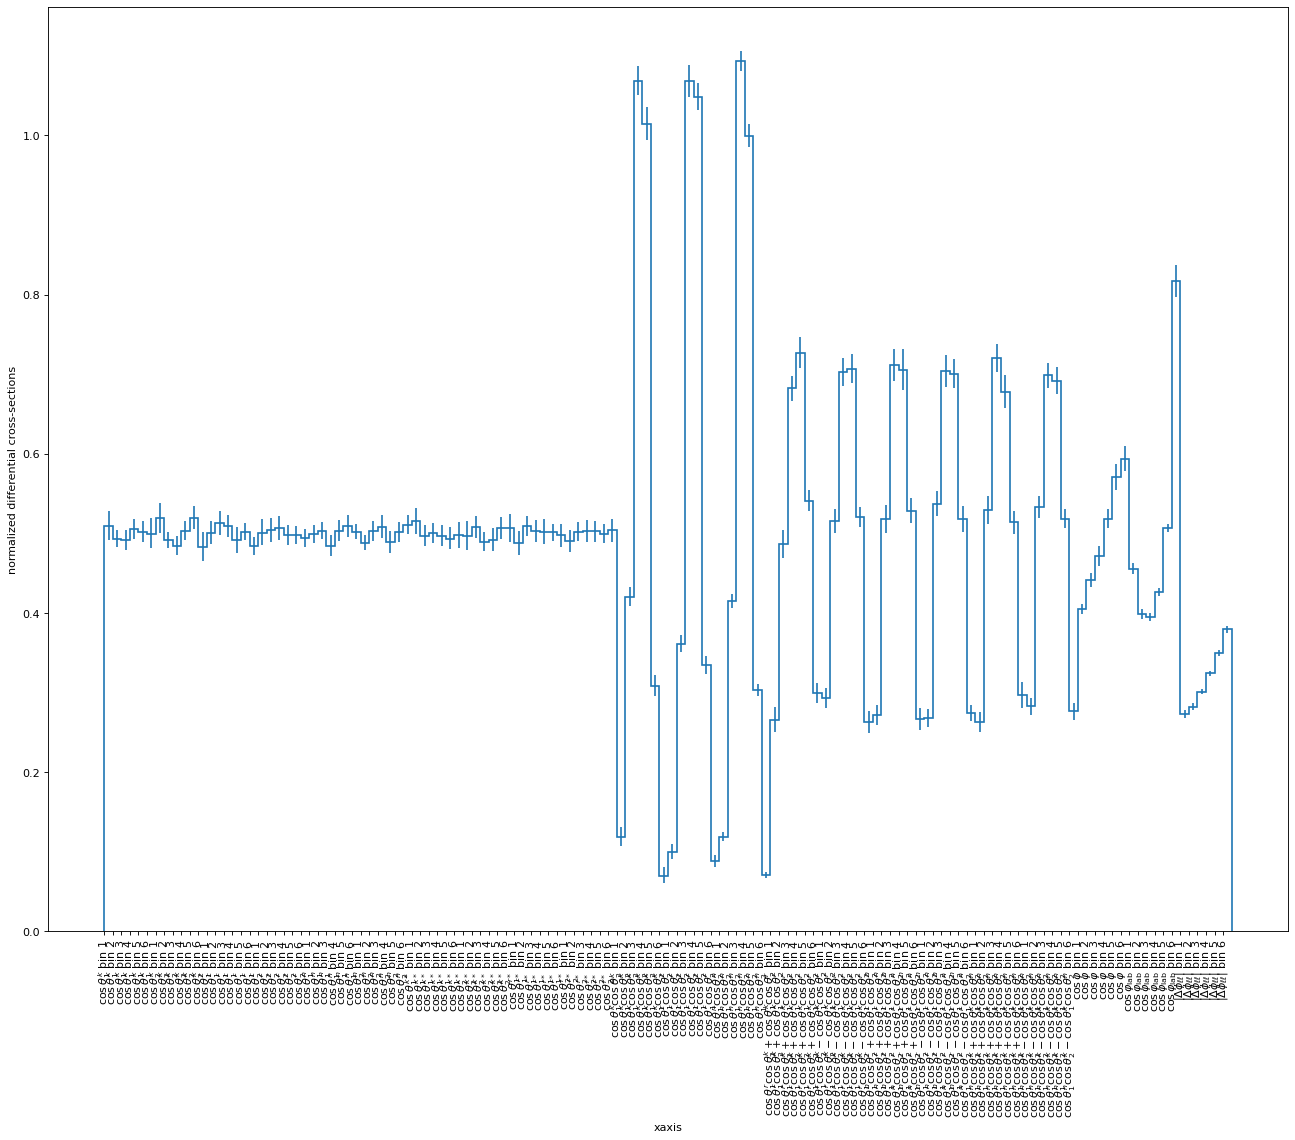

In [358]:
plt.figure(figsize=(20, 15), dpi=80)
h_concatenated['concatenated_diff_cross_section;1'].to_hist().plot1d()
plt.ylabel("normalized differential cross-sections") 
plt.xticks(ticks=range(len(xy_labels[0])), labels=xy_labels[0], rotation=90);
plt.savefig("concatenated_histograms.pdf")

In [306]:
file_cov = uproot.open('covariance_matrix/statistical_covariance_matrix.root')

In [307]:
file_cov['covariance_matrix;1']

<TH2F (version 4) at 0x7f0f32da8a60>